In [136]:
import geopandas as gpd
import pandas as pd
import numpy as np
from datetime import date
import glob
import geopandas as gpd
import sys
import os
import chardet
import ast
import regex as re
from datetime import datetime, timedelta

In [137]:
# import local functions
current_dir = os.path.abspath('..')
if current_dir not in sys.path:
    sys.path.append(current_dir)
import standardize_pft_funcs as spf

---
---
# 1. Pre-processing <a name="preprocess"></a>
After visually inspecting each fcover and "habit" table for obvious errors, we saved the cleaned tables to a folder that we then standardized here. Where necessary, cleaning included:
- Dropping extra rows
- Renaming columns that were misnamed (e.g. sometimes "field releve number" and "releve number" were switched)
- Moving headers to the first row of the table

In [138]:
source = 'rava'

---
## 1.1. Auxiliary information

In [139]:
# get paths to tables
aux_csv_paths = sorted(glob.glob(f'input_data/rava_cover_tables/*habitat_data.csv'))

In [140]:
# load tables in pandas; not all tables have known encoding
aux_dfs = []
for path in aux_csv_paths:
    with open(path, 'rb') as file:
        # dynamically detect file encoding because it is not consistent
        result = chardet.detect(file.read())
    df = pd.read_csv(path, encoding=result['encoding'], encoding_errors='replace', 
                     na_values=[-9, -9.0, '-9', '-9.0'], header=0, skiprows=[1]) # skip column descriptor
    df['source_name'] = path.split('/')[-1].split('_habitat_data.csv')[0]
    aux_dfs.append(df)
aux_dfs[3].head(3)

,RELEVE NUMBER,FIELD RELEVE NUMBER,DATE (YEARMONTHDAY),RELEVE AREA (M2),RELEVE SHAPE,COVERSCALE,REPEAT SAMPLED (Y/N),COLLECTION,COLLECTION METHOD,SYNTAXON CODE,...,COVER OPEN WATER (%),COVER LITTER LAYER (%),COVER TOTAL (%),MEAN CANOPY HEIGHT (CM),MEAN TREE LAYER HEIGHT (CM),MEAN SHRUB LAYER HEIGHT (CM),MEAN HERB LAYER HEIGHT (CM),MEAN MOSS LAYER HEIGHT (CM),REMARKS,source_name
0,NaN,G1-1,7/10/2017,NaN,NaN,0,1,N,R,NaN,...,0,0.1,95,NaN,NaN,NaN,NaN,NaN,NaN,AVARU_G1_Yambuto_lake_eltroeva_2017
1,NaN,G1-4,7/10/2017,NaN,NaN,0,1,N,R,NaN,...,0,50.0,100,NaN,NaN,NaN,NaN,NaN,NaN,AVARU_G1_Yambuto_lake_eltroeva_2017
2,NaN,G1-5,7/10/2017,NaN,NaN,0,1,N,R,NaN,...,0,15.0,100,NaN,NaN,NaN,NaN,NaN,NaN,AVARU_G1_Yambuto_lake_eltroeva_2017


In [141]:
# get data after 2010
aux_df = pd.concat(aux_dfs)
aux_df['DATE (YEARMONTHDAY)'] = aux_df['DATE (YEARMONTHDAY)'].astype(str).str.replace(" ", "")
grouped = aux_df.groupby('DATASET')['DATE (YEARMONTHDAY)'].agg(lambda x: ', '.join(x.unique())).reset_index()
grouped.to_csv(f'temp_data/{source}_date_formats.csv')

### 1.1.1. Fix date issues

In [142]:
# read assigned date strftimes
datetimes = pd.read_csv(f'temp_data/{source}_date_formats_01.csv', index_col=0)
datetimes

,DATASET,DATE (YEARMONTHDAY),datetime_formats,dayfirst
0,Bolshevik_island,NaN,NaN,NaN
1,Bolshezemelskaya Tundra,"20150726, 20150808, 20160721, 20150811, 201507...",%Y%m%d,False
2,Dedov's_historical_data,"14.08.1931, 12.08.1928, 7.08.1928, 21.08.1931,...",%d.%m.%Y,True
3,EAT,"20070806, 20070808, 20070815, 20070817, 200708...",%Y%m%d,False
4,G1_Yambuto_lake,"7/10/2017, 7/11/2017, 7/12/2017, 7/13/2017, 7/...","%m/%d/%Y, %Y%m%d","False, False"
...,...,...,...,...
92,Svalbard,"05.08.2018, 03.08.2018, 06.07.2018, 15.07.1985...","%d.%m.%Y, %d-%d.%m.%Y, %Y-%Y","True, True, False"
93,Tazovsky_peninsula,"20170731, 20170802, 20170803, 20170804, 20170806",%Y%m%d,False
94,Wrangel_island,NaN,NaN,NaN
95,gava2_mtelyatnikov,"20170720.0, 20170721.0, 20170722.0, 20170723.0...",%Y%m%d.0,False


In [143]:
# read the terirble csv I made (hence the safe_eval function)
def safe_eval(value, return_list=False):
    """Safely evaluate a string representation of a list, tuple, or single value.
       Returns [] for NaN if return_list=True, otherwise None."""
    if isinstance(value, float) and np.isnan(value):  # Handle NaN values
        return [] if return_list else None
    try:
        parsed_value = ast.literal_eval(value)  # Safely evaluate Python literals
        if isinstance(parsed_value, tuple):  # Convert tuples to lists
            return list(parsed_value)
        elif return_list and not isinstance(parsed_value, list):  # Ensure list format
            return [parsed_value]
        return parsed_value
    except (ValueError, SyntaxError):
        return [v.strip() for v in value.split(",")] if return_list else value.strip()

# and turn it into a dictionary so I can set datetime objects based on dataset
source_formats = {
    row['DATASET']: {
        'datetime_formats': safe_eval(row['datetime_formats'], return_list=True),
        'dayfirst': safe_eval(row['dayfirst'], return_list=True)  # Ensure always a list
    }
    for _, row in datetimes.iterrows()
}

In [144]:
# do a whole lot to fix the date situation
def clean_datetime_string(date_str):
    """Cleans and standardizes datetime strings."""
    if isinstance(date_str, float) and np.isnan(date_str):
        return None  # Convert NaN to None
    return str(date_str).strip()  # Ensure it's a string and remove whitespace

def fix_specific_dates(date_str):
    """Manually fixes known incorrect dates."""
    if date_str == "05.08.218":
        return "05.08.2018"
    return date_str

def find_midpoint_date(start_date, end_date):
    """Find the midpoint between two datetime objects."""
    midpoint = start_date + (end_date - start_date) / 2
    return midpoint

def parse_date_range(date_str):
    """Detects date ranges and computes the midpoint date."""
    # Manually fix known incorrect dates first
    date_str = fix_specific_dates(date_str)

    # Match Year Ranges (e.g., 1992-1996)
    year_range_match = re.fullmatch(r"(\d{4})-(\d{4})", date_str)
    if year_range_match:
        start_year, end_year = map(int, year_range_match.groups())
        start_date = datetime(start_year, 1, 1)
        end_date = datetime(end_year, 12, 31)
        return find_midpoint_date(start_date, end_date).strftime("%Y-%m-%d")

    # Match Day Ranges with Month/Year (e.g., 27-28.07.1964)
    day_range_match = re.fullmatch(r"(\d{1,2})-(\d{1,2})\.(\d{1,2})\.(\d{4})", date_str)
    if day_range_match:
        start_day, end_day, month, year = map(int, day_range_match.groups())
        start_date = datetime(year, month, start_day)
        end_date = datetime(year, month, end_day)
        return find_midpoint_date(start_date, end_date).strftime("%Y-%m-%d")

    return None  # Not a recognized range

def process_datetime(row, date_col, formats):
    """Infer date and time from a string using source-specific formats."""
    try:
        original_date = row[date_col]
        date_str = clean_datetime_string(original_date)

        # If the cleaned date is empty or NaN, return None
        if not date_str:
            return original_date, None, None, None

        # Manually fix specific incorrect dates
        date_str = fix_specific_dates(date_str)

        # Check if it's a date range and find the midpoint
        midpoint_date = parse_date_range(date_str)
        if midpoint_date:
            parsed_date = pd.to_datetime(midpoint_date, format="%Y-%m-%d")
            return original_date, parsed_date.year, parsed_date.month, parsed_date.day

        # Initialize year, month, day as None
        year_str, month_str, day_str = None, None, None

        # Check if formats exist
        datetime_formats = formats.get("datetime_formats", [])
        if not datetime_formats:
            return original_date, None, None, None

        # Try parsing with available formats
        for fmt in datetime_formats:
            try:
                parsed_date = pd.to_datetime(date_str, format=fmt, errors='coerce')

                # If parsing was successful, extract components
                if not pd.isna(parsed_date):
                    year_str, month_str, day_str = parsed_date.year, parsed_date.month, parsed_date.day
                    break
            except Exception as e:
                print(f"Error parsing {date_str} with {fmt}: {e}")
                continue

        return original_date, year_str, month_str, day_str
    except Exception as e:
        print(f"Unexpected error: {e}")
        return row[date_col], None, None, None

# Apply processing by group
results = []
for datasource, group in aux_df.groupby('DATASET'):
    formats = source_formats.get(datasource, {})

    # Ensure correct application
    processed = group.apply(
        lambda x: pd.Series(process_datetime(x, 'DATE (YEARMONTHDAY)', formats)), axis=1
    )

    # Assign back to the DataFrame
    group[['original_date', 'survey_year', 'survey_month', 'survey_day']] = processed.values

    results.append(group)

aux_df2 = pd.concat(results)

In [145]:
# ensure year is a numeric
aux_df2['survey_year'] = pd.to_numeric(aux_df2['survey_year'], errors='coerce')

### 1.1.3. Fix duplicate column issues

In [146]:
# reset index and standardize col names
aux_df2 = aux_df2.reset_index(drop=True)
aux_df2.columns = aux_df2.columns.str.strip()

# define duplicate column mappings
column_merges = {
    "LONGITUDE WGS 84 (DD)": "LONGITUDEWGS84'(DD)",
    "HABITAT TYPE": "HABITAT TYPE ",
    "REMARKS": "REBMARKS",
    "SITE MOISTURE": "SITEMOISTURE",
    "RELEVE NUMBER": "RELEVE_NUMBER",
}

# merge duplicate columns where applicable
for correct_col, incorrect_col in column_merges.items():
    if correct_col in aux_df2.columns and incorrect_col in aux_df2.columns:
        # Merge using .fillna() instead of .combine_first()
        aux_df2[correct_col] = aux_df2[correct_col].fillna(aux_df2[incorrect_col])
        aux_df2.drop(columns=[incorrect_col], inplace=True)

In [147]:
# function to clean coordinate values (found one with a comma???)
def clean_coordinates(value):
    if isinstance(value, str):
        value = value.strip().rstrip(',')  # Remove spaces and trailing commas
    try:
        return float(value)  # Convert to float
    except ValueError:
        return np.nan  # Set invalid values to NaN

# apply cleaning function to longitude and latitude columns
aux_df2['LONGITUDE WGS 84 (DD)'] = aux_df2['LONGITUDE WGS 84 (DD)'].apply(clean_coordinates)
aux_df2['LATITUDE WGS 84 (DD)'] = aux_df2['LATITUDE WGS 84 (DD)'].apply(clean_coordinates)

# drop rows where longitude or latitude is NaN (invalid coordinates)
aux_df2 = aux_df2.dropna(subset=['LONGITUDE WGS 84 (DD)', 'LATITUDE WGS 84 (DD)'])

# create GeoDataFrame with cleaned coordinates
rava_points = gpd.GeoDataFrame(
    aux_df2,
    geometry=gpd.points_from_xy(aux_df2['LONGITUDE WGS 84 (DD)'], aux_df2['LATITUDE WGS 84 (DD)']), 
    crs='EPSG:4326'
)

In [148]:
# load the local shapefile using geopandas
path = '../etc/circumpolar_bioclim/aga_circumpolar_geobotanical_2003.shp'
tundra = gpd.read_file(path)
rava_points = rava_points.to_crs(tundra.crs)
rava_points = rava_points.clip(tundra)

<Axes: >

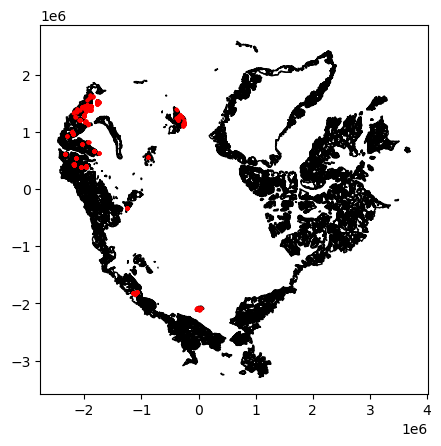

In [149]:
# plot the russian tundra points
ax = tundra.plot(edgecolor='black', facecolor='none')
rava_points.plot(ax=ax, color='red', markersize=3)

In [150]:
# print a list of the AVA datasets we will be harmonizing
rava_datasets = sorted(rava_points['source_name'].unique())
print(sorted(rava_datasets))

['AVARU_AAVA_EAT_Walker_et_al', 'AVARU_Bolshezemelskaya_tundra_Lavrinenko_O_I_2015_2016', 'AVARU_G1_Yambuto_lake_eltroeva_2017', 'AVARU_G1_Yambuto_lake_mtelyatnikov_2017', 'AVARU_G2_Northern_Gydan_eltroeva_2017', 'AVARU_G2_Northern_Gydan_mtelyatnikov_2017', 'AVARU_G3_Tanama_river_olkhitun_2017', 'AVARU_G4_Parisento_lake_olkhitun_2017', 'AVARU_Indigirka_mtelyatnikov_eltroeva_2013', 'AVARU_Malozemelskaya_tundra_Lavrinenko_O_I_2001_2007', 'AVARU_Oxycocco_Sphagnetea_Lavrinenko_O_I_2015', 'AVARU_Polar_Ural_3_mtelyatnikov_2018', 'AVARU_Polar_Ural_4_mtelyatnikov_2018', 'AVARU_Scheuchzerio_Caricetea_Lavrinenko_1998_2016', 'AVARU_Svalbard_Koroleva_et_al', 'AVARU_T1_Tazovsky_peninsula_olkhitun_2017', 'AVARU_Wrangel_Kholod', 'AVARU_Ya1_Northern_Yamal_eltroeva_2017', 'AVARU_Ya1_Northern_Yamal_mtelyatnikov_2017', 'AVA_RU_Bolshevik_Matveyeva_2006']


### 1.1.4. Exatract auxialiary-only information (non-cover)

In [151]:
rava_points.columns

Index(['FIELD RELEVE NUMBER', 'DATE (YEARMONTHDAY)', 'RELEVE AREA (M2)',
       'RELEVE SHAPE', 'COVERSCALE', 'REPEAT SAMPLED (Y/N)', 'COLLECTION',
       'COLLECTION METHOD', 'SYNTAXON CODE', 'SYSTEM FOR PLANT COMMUNITY NAME',
       'PLANT COMMUNITY NAME', 'AUTHOR CODE', 'REFERENCE FOR SPECIES DATA',
       'TABLE NUMBER FOR SPECIES DATA', 'NUMBER OF RELEVE IN TABLE',
       'REFERENCE FOR ENVIRONMENTAL DATA',
       'TABLE NUMBER FOR ENVIRONMENTAL DATA', 'SUBZONE', 'COUNTRY CODE',
       'DATASET', 'REGION', 'LOCATION', 'PHYSIOGRAPHIC DIVISION',
       'PHYSIOGRAPHIC REGION SOURCE', 'GEOREFERENCE (Y/N)',
       'GEOREFERENCE SOURCE', 'GEOREFERENCE ACCURACY (M)',
       'LATITUDE WGS 84 (DD)', 'ALTITUDE (M)', 'SLOPE (DEGREES)',
       'ASPECT (DEGREES)', 'TOPOGRAPHIC POSITION', 'SURFICIAL GEOLOGY',
       'HABITAT TYPE', 'SITE MOISTURE', 'DISTURBANCE',
       'ORGANIC LAYER DEPTH (CM)', 'SOIL TEXTURE  TOP MINERAL HORIZON',
       'SOIL PH (at 10 cm)', 'MOSSES IDENTIFIED (Y/N)',
     

In [152]:
# set the plot (index) names from dataset + field releve number
# I cant include the date/vist in the VisitName because my fcover and habitat files are separated
# I'll just have to check the plotVisitNames with duplicated coords
rava_points.columns = [col.lower().replace(' ', '_') for col in rava_points.columns]
rava_points['plotVisitName'] = rava_points['source_name'] + '_' + rava_points['field_releve_number'].astype(str)
rava_points['plotName'] = rava_points['source_name'] + '_' + rava_points['field_releve_number'].astype(str)
rava_points.set_index('plotVisitName', inplace=True)

In [153]:
# extract columns that DO NOT have "cover" in the name; this is auxiliary info
aux_cols = [col for col in rava_points.columns if 'cover' not in col]
aux = rava_points[aux_cols].copy()
aux.head(3)

,field_releve_number,date_(yearmonthday),releve_area_(m2),releve_shape,repeat_sampled_(y/n),collection,collection_method,syntaxon_code,system_for_plant_community_name,plant_community_name,...,remarks,source_name,releve_number,longitude_wgs_84_(dd),original_date,survey_year,survey_month,survey_day,geometry,plotName
plotVisitName,,,,,,,,,,,,,,,,,,,,,
AVARU_Wrangel_Kholod_30c,30c,nan,NaN,NaN,NaN,R,NaN,16,B-B,Association Oxytropidi wrangelii-Diyadetum int...,...,in orig. cover for vascular plants is 55%,AVARU_Wrangel_Kholod,20753.0,-179.603741,nan,NaN,None,None,POINT (14637.664 -2116451.645),AVARU_Wrangel_Kholod_30c
AVARU_Wrangel_Kholod_82c,82c,nan,NaN,NaN,NaN,R,NaN,16,B-B,Association Oxytropidi wrangelii-Diyadetum int...,...,in orig. cover for vascular plants is 50%,AVARU_Wrangel_Kholod,20739.0,-179.583093,nan,NaN,None,None,POINT (15393.313 -2115474.954),AVARU_Wrangel_Kholod_82c
AVARU_Wrangel_Kholod_293c,293c,nan,NaN,NaN,NaN,R,NaN,16,B-B,Association Oxytropidi wrangelii-Diyadetum int...,...,in orig. cover for vascular plants is 60%,AVARU_Wrangel_Kholod,20745.0,-179.583438,nan,NaN,None,None,POINT (15377.706 -2115080.457),AVARU_Wrangel_Kholod_293c


---
## 1.3. Percent Cover Data

### 1.3.1. Exatract non-foliar cover info from auxiliary

In [154]:
# extract columns with "cover" in the name; these contain the fcover data
cover_cols = [col for col in rava_points.columns if 'cover' in col]
nonfoliar_fcover = rava_points[cover_cols].copy()
nonfoliar_fcover.drop(columns=['coverscale'], inplace=True) # not fcover

In [155]:
# extract non-vegetation fcover columns
etc = ['cover_crust(%)','cover_bare_soil_(%)','cover_bare_rock_(%)','cover_open_water_(%)']
non_veg = nonfoliar_fcover[etc]
litter = nonfoliar_fcover[['cover_litter_layer_(%)']]

# Remove the stuff we pulled out
etc.append('cover_litter_layer_(%)')
nonfoliar_fcover.drop(columns=etc, inplace=True)

### 1.3.2. Extract foliar fcover data

In [156]:
# get paths to tables
species_csv_paths = sorted(glob.glob(f'input_data/rava_cover_tables/*fcover_data.csv'))

In [157]:
# load tables in pandas; not all tables have known encoding
fcover_dfs = []
for path in species_csv_paths:
    with open(path, 'rb') as file:
        # dynamically detect file encoding because it is not consistent
        result = chardet.detect(file.read())
    df = pd.read_csv(path, encoding=result['encoding'], encoding_errors='replace', 
                     na_values=[-9, -9.0, '-9', '-9.0'], header=0, skiprows=[1]) # skip the turboveg plot id row
    fcover_dfs.append(df)
fcover_dfs[3].head(3)

,PASL TAXON SCIENTIFIC NAME NO AUTHOR(S),PASL TAXON SCIENTIFIC NAME WITH AUTHOR(S),DATASET TAXON,G1-1,G1-4,G1-5,G1-10,G1-11,G1-14,G1-16,...,G1-136,G1-138,G1-140,G1-142,G1-144,G1-146,G1-148,G1-150,G1-152,G1-154
0,Abietinella abietina,Abietinella abietina (Hedw.) Fleisch.,Abietinella abietina,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Achoriphragma nudicaule,Parrya nudicaulis (L.) Regel,Achoriphragma nudicaule,0,2,3,0,2,0,0,...,0,0,0,0,2,0,0,0,0,0
2,Alectoria ochroleuca,Alectoria ochroleuca (Hoffm.) Massal.,Alectoria ochroleuca,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0


In [158]:
# get unique species names from all tables
species_names = []
for df in fcover_dfs: 
    names = df.iloc[:, 1] # second col with author (I found that no-author names didn't align with authored names)
    for name in names:
        if pd.notnull(name):
            name = name.strip('[]')
            name = name.strip()
            species_names.append(name)
u_species_names = list(set(species_names))

# remove null species names
u_species_names = [x for x in u_species_names if pd.notnull(x)]
print('Non-nan unique species names for ALL fcover data: ', len(u_species_names))
species_names_df = pd.DataFrame(u_species_names, columns=['datasetSpeciesName'])

Non-nan unique species names for ALL fcover data:  1988


---
## 1.4. Join fcover to species checklist table

In [159]:
# load species checklist and prep for joining
checklist_path = '../etc/akveg_species_checklist.csv'
checklist_df = spf.checklist_df(checklist_path)
checklist_df.head(3)

,nameCode,checklistSpeciesName,nameStatus,nameAccepted,nameFamily,acceptedNameSource,nameLevel,speciesForm,speciesHabit
0,abroth,Abrothallus De Not.,accepted,Abrothallus De Not.,Abrothallaceae,CNALH,genus,lichen,lichen
1,abrpar,Abrothallus parmeliarum (Sommerf.) Arnold,accepted,Abrothallus parmeliarum (Sommerf.) Arnold,Abrothallaceae,CNALH,species,lichen,lichen
2,abrpey,Abrothallus peyritschii (Stein) Kotte,accepted,Abrothallus peyritschii (Stein) Kotte,Abrothallaceae,Dillman et al. 2012,species,lichen,lichen


In [160]:
species_names_df.head(3)

,datasetSpeciesName
0,Epilobium lactiflorum Hausskn.
1,Trisetum spicatum (L.) K. Richt.
2,Hedysarum hedysaroides (L.) Schinz & Thell.


In [161]:
# get first 2 words (genus-species) from checklist accepted name and data species name
checklist_df['joinKey'] = checklist_df['checklistSpeciesName'].apply(spf.get_substrings)
species_names_df['joinKey'] = species_names_df['datasetSpeciesName'].apply(spf.get_substrings)
habits = spf.join_to_checklist(unique_species=species_names_df, 
                               checklist=checklist_df, 
                               u_name='datasetSpeciesName', 
                               c_unofficial_name='checklistSpeciesName', 
                               c_official_name='nameAccepted', 
                               mapping_name='joinKey',
                               habit='speciesHabit')
habits.head(3)

708 species are missing habits.
432 species still missing habits.
69 species still missing habits.
50 species still missing habits.


,datasetSpeciesName,joinKey,speciesHabit
index,,,
0,Epilobium lactiflorum Hausskn.,Epilobium lactiflorum,forb
1,Trisetum spicatum (L.) K. Richt.,Trisetum spicatum,graminoid
2,Hedysarum hedysaroides (L.) Schinz & Thell.,Hedysarum hedysaroides,forb


In [162]:
species_names_df.head(3)

,datasetSpeciesName,joinKey
0,Epilobium lactiflorum Hausskn.,Epilobium lactiflorum
1,Trisetum spicatum (L.) K. Richt.,Trisetum spicatum
2,Hedysarum hedysaroides (L.) Schinz & Thell.,Hedysarum hedysaroides


In [163]:
habits = species_names_df.merge(habits, how='left', left_on='datasetSpeciesName', right_on='datasetSpeciesName', suffixes=(None, '_1'))
habits = habits[['joinKey', 'datasetSpeciesName', 'speciesHabit']]

---
## 1.5. Join fcover to leaf retention table

In [164]:
# load leaf retention table and clean
path = '../etc/macander_leaf_retention.csv'
leaf_ret = spf.leaf_retention_df(path)
leaf_ret.head(3)

,leafRetention,retentionSpeciesName
0,deciduous,Salix
1,deciduous,Betula nana
2,deciduous,Vaccinium uliginosum


In [165]:
# add leaf retention column
habits_wleaf = spf.add_leaf_retention(habits, leaf_ret, 'leafRetention')
habits_wleaf = habits_wleaf[['datasetSpeciesName', 'joinKey', 'speciesHabit', 'leafRetention']]
habits_wleaf.head(3)

,datasetSpeciesName,joinKey,speciesHabit,leafRetention
0,Epilobium lactiflorum Hausskn.,Epilobium lactiflorum,forb,
1,Trisetum spicatum (L.) K. Richt.,Trisetum spicatum,graminoid,
2,Hedysarum hedysaroides (L.) Schinz & Thell.,Hedysarum hedysaroides,forb,


In [166]:
# apply function
habits_wleaf['speciesHabit'] = habits_wleaf['speciesHabit'].apply(spf.clean_shrub_habits)
list(habits_wleaf['speciesHabit'].unique())

['forb',
 'graminoid',
 'lichen',
 'moss',
 'shrub',
 nan,
 'spore-bearing',
 'liverwort',
 'coniferous tree']

---
## 1.6. Export species-PFT tables

In [167]:
# generate 3 files and dataframe of habit types
shrubs, nonshrubs, null = spf.export_habit_files(habits_wleaf,
                                                 'temp_data', 
                                                 source, 
                                                 'speciesHabit')

In [168]:
# check to make sure the files make sense
len(habits_wleaf) == (len(null) + len(nonshrubs) + len(shrubs))

True

---
## 1.7. Clean exported species-PFT tables <a name="cleanhabits"></a>
Here, we manually assessed each file. The nonshrubs were usually correct and did not have to be adjusted. Some shrubs were missing leaf retention information, so we consulted with arctic ecologists to determine it. For unknown (null) habits, we consulted arctic ecology expert, Amy Breen, to determine the issue and correct habit. After the tables were complete, all species names had a single associated habit.
- null habits
    - assign missing habits and consult ecologist when needed
- non-shrubs
    - assign leaf habit to all trees (ctrl-f to find all trees in excel)
        - coniferous tree = evergreen
        - deciduous tree  = deciduous
    - remove leaf habit if misapplied
- shrubs
    - check current leaf habits and correct if necessary
    - fill empty leaf habits
    - choose leaf habit if both evergreen & deciduous listed
    - add Stature column (dwarf shrub or not)

---
---
# 2. Standardization <a name="standardization"></a>

---
## 2.1. Standardize PFT names <a name="pftnames"></a>
deciduous shrub, evergreen shrub, graminoid, forb, litter, non-vascular (lichen, brophyte)

In [169]:
# paths to visually assessed and cleaned habit files
all_habit_types = [f'temp_data/{source}_nonshrubs_01.csv',
                   f'temp_data/{source}_shrubs_01.csv',
                   f'temp_data/{source}_nullhabit_01.csv']

# create list of habit dataframes
habit_dfs = []
for path in all_habit_types:
    habit_df = pd.read_csv(path, index_col=0)
    habit_dfs.append(habit_df)
all_habits = pd.concat(habit_dfs)

In [170]:
# show unique habit names we're working with
all_habits['speciesHabit'].unique().tolist()

['graminoid',
 'moss',
 'forb',
 'lichen',
 'spore-bearing',
 'liverwort',
 'shrub',
 'tree',
 'bryophyte',
 'other']

In [171]:
# ava-specific habit name standardization function
def standardize_habit(habitrow, leafrow):
    
    habitrow = habitrow.to_numpy()
    leafrow = leafrow.to_numpy()
    new_row = []
    
    for habit, leaf in zip(habitrow, leafrow):
        
        habit = habit.lower()
        # non-shrubs
        if 'moss' in habit or 'liverwort' in habit:
            new_habit = 'bryophyte'
        elif 'spore-bearing' in habit:
            new_habit = 'forb'
            
        # shrubs and trees
        elif 'shrub' in habit:
            new_habit = f'{leaf} shrub'
        elif 'tree' in habit:
            new_habit = f'{leaf} tree'
            
        else:
            new_habit = f'{habit}'
        new_row.append(new_habit)
    
    return new_row

In [172]:
# standardized PFT
standard_habit_col = standardize_habit(all_habits['speciesHabit'], 
                                       all_habits['leafRetention'])
all_habits['standardHabit'] = standard_habit_col
all_habits.rename(columns={'speciesHabit':'nonstandardHabit'}, inplace=True)
print(len(all_habits))
all_habits.head(3)

1988


,datasetSpeciesName,joinKey,nonstandardHabit,leafRetention,standardHabit
0,Juncus biglumis,Juncus biglumis,graminoid,NaN,graminoid
1,Calliergon cordifolium (Hedw.) Kindb.,Calliergon cordifolium,moss,NaN,bryophyte
2,Angelica archangelica [s. archangelica] L.,Angelica archangelica,forb,NaN,forb


---
## 2.2. Sum species fcover to PFT-level

#### Cover scale codes:
0 = percent

BB = braun blanquet

2 = braun blanquet

In [173]:
# Assign cover scale to each CSV file
rava_datasets = rava_points[['source_name', 'coverscale']].to_numpy().tolist()
rava_datasets = list(map(list, {tuple(lst) for lst in rava_datasets}))
rava_datasets

[['AVARU_Ya1_Northern_Yamal_mtelyatnikov_2017', 0],
 ['AVARU_G4_Parisento_lake_olkhitun_2017', 0],
 ['AVARU_G1_Yambuto_lake_eltroeva_2017', 0],
 ['AVARU_Oxycocco_Sphagnetea_Lavrinenko_O_I_2015', nan],
 ['AVARU_T1_Tazovsky_peninsula_olkhitun_2017', 0],
 ['AVARU_G2_Northern_Gydan_mtelyatnikov_2017', 0],
 ['AVARU_Indigirka_mtelyatnikov_eltroeva_2013', 0],
 ['AVARU_AAVA_EAT_Walker_et_al', 'BB'],
 ['AVARU_G2_Northern_Gydan_eltroeva_2017', 0],
 ['AVA_RU_Bolshevik_Matveyeva_2006', 1],
 ['AVARU_G1_Yambuto_lake_mtelyatnikov_2017', 0],
 ['AVARU_Polar_Ural_3_mtelyatnikov_2018', 0],
 ['AVARU_G3_Tanama_river_olkhitun_2017', 0],
 ['AVARU_Bolshezemelskaya_tundra_Lavrinenko_O_I_2015_2016', 2],
 ['AVARU_Malozemelskaya_tundra_Lavrinenko_O_I_2001_2007', 2],
 ['AVARU_Ya1_Northern_Yamal_eltroeva_2017', 0],
 ['AVARU_Wrangel_Kholod', 2],
 ['AVARU_Svalbard_Koroleva_et_al', nan],
 ['AVARU_Scheuchzerio_Caricetea_Lavrinenko_1998_2016', 2],
 ['AVARU_Polar_Ural_4_mtelyatnikov_2018', 0]]

In [174]:
# Create mapping dictionary with dataset names as keys
code_mapping = {}
for file_path in species_csv_paths:
    for source_name, code in rava_datasets:
        # Extract data source from file name
        if source_name in file_path:
            code_mapping[source_name] = [file_path, code]
            break  # Stop searching once we find a match

# Reverse the code_translations dictionary for easy lookup
code_translations = {'percent': [0], 'braun_blanquet': ['BB', 2]}
translated_codes = {value: key for key, values in code_translations.items() for value in values}

# Create a new dictionary with dataset names as keys and paths + translated codes as values
code_translated_mapping = {
    dataset_name: [path, translated_codes.get(code, code)]  
    for dataset_name, (path, code) in code_mapping.items()
}

# Print the updated mapping
print(code_translated_mapping)

{'AVARU_AAVA_EAT_Walker_et_al': ['input_data/rava_cover_tables/AVARU_AAVA_EAT_Walker_et_al_fcover_data.csv', 'braun_blanquet'], 'AVARU_Bolshezemelskaya_tundra_Lavrinenko_O_I_2015_2016': ['input_data/rava_cover_tables/AVARU_Bolshezemelskaya_tundra_Lavrinenko_O_I_2015_2016_fcover_data.csv', 'braun_blanquet'], 'AVARU_G1_Yambuto_lake_eltroeva_2017': ['input_data/rava_cover_tables/AVARU_G1_Yambuto_lake_eltroeva_2017_fcover_data.csv', 'percent'], 'AVARU_G1_Yambuto_lake_mtelyatnikov_2017': ['input_data/rava_cover_tables/AVARU_G1_Yambuto_lake_mtelyatnikov_2017_fcover_data.csv', 'percent'], 'AVARU_G2_Northern_Gydan_eltroeva_2017': ['input_data/rava_cover_tables/AVARU_G2_Northern_Gydan_eltroeva_2017_fcover_data.csv', 'percent'], 'AVARU_G2_Northern_Gydan_mtelyatnikov_2017': ['input_data/rava_cover_tables/AVARU_G2_Northern_Gydan_mtelyatnikov_2017_fcover_data.csv', 'percent'], 'AVARU_G3_Tanama_river_olkhitun_2017': ['input_data/rava_cover_tables/AVARU_G3_Tanama_river_olkhitun_2017_fcover_data.csv',

In [175]:
# Add missing code assignments
bb_files = ['input_data/rava_cover_tables/AVARU_Bolshezemelskaya_tundra_Lavrinenko_O_I_2015_2016_fcover_data.csv',
            'input_data/rava_cover_tables/AVARU_Kola_peninsula_Floodplains_NKoroleva_1930-2016_fcover_data.csv',
            'input_data/rava_cover_tables/AVARU_Kola_peninsula_tundra_meadows_NKoroleva_1930-2016_fcover_data.csv',
            'input_data/rava_cover_tables/AVARU_Malozemelskaya_tundra_Lavrinenko_O_I_2001_2007_fcover_data.csv',
            'input_data/rava_cover_tables/AVARU_Oxycocco_Sphagnetea_Lavrinenko_O_I_2015_fcover_data.csv',
            'input_data/rava_cover_tables/AVARU_Scheuchzerio_Caricetea_Lavrinenko_1998_2016_fcover_data.csv',
            'input_data/rava_cover_tables/AVARU_Scandinavia_historical_fcover_data.csv',
            'input_data/rava_cover_tables/AVARU_Svalbard_Koroleva_et_al_fcover_data.csv',
            'input_data/rava_cover_tables/AVARU_Wrangel_Kholod_fcover_data.csv',
            'input_data/rava_cover_tables/AVA_RU_Bolshevik_Matveyeva_2006_fcover_data.csv']

mod_bb_files = ['input_data/rava_cover_tables/AVARU_AnDedov_1928_1939_fcover_data.csv']

perc_files = ['input_data/rava_cover_tables/AVARU_Polar_Ural_1_mtelyatnikov_2018_fcover_data.csv',
              'input_data/rava_cover_tables/AVARU_Polar_Ural_2_mtelyatnikov_2018_fcover_data.csv',
              'input_data/rava_cover_tables/AVARU_G2_Northern_Gydan_mtelyatnikov_2017_fcover_data.csv',
              'input_data/rava_cover_tables/AVARU_G2_Northern_Gydan_eltroeva_2017_fcover_data.csv',
              'input_data/rava_cover_tables/AVARU_Ya1_Northern_Yamal_mtelyatnikov_2017_fcover_data.csv',
              'input_data/rava_cover_tables/AVARU_Ya1_Northern_Yamal_eltroeva_2017_fcover_data.csv']

drude_files = ['input_data/rava_cover_tables/AVARU_Taymyr_Pospelovs_fcover_data.csv']

# Define the new mappings with formatted dataset names as keys
new_mappings = {
    file: ['braun_blanquet'] for file in bb_files
}
new_mappings.update({file: ['modified_braun_blanquet'] for file in mod_bb_files})
new_mappings.update({file: ['percent'] for file in perc_files})
new_mappings.update({file: ['drude'] for file in drude_files})

# Update existing dictionary with dataset names as keys
for file_path, (code_list) in new_mappings.items():
    dataset_name_formatted = file_path.split('/')[-1].replace('_fcover_data.csv', '')
    code_translated_mapping[dataset_name_formatted] = [file_path, code_list[0]]

# Print the updated mapping
print(code_translated_mapping)

{'AVARU_AAVA_EAT_Walker_et_al': ['input_data/rava_cover_tables/AVARU_AAVA_EAT_Walker_et_al_fcover_data.csv', 'braun_blanquet'], 'AVARU_Bolshezemelskaya_tundra_Lavrinenko_O_I_2015_2016': ['input_data/rava_cover_tables/AVARU_Bolshezemelskaya_tundra_Lavrinenko_O_I_2015_2016_fcover_data.csv', 'braun_blanquet'], 'AVARU_G1_Yambuto_lake_eltroeva_2017': ['input_data/rava_cover_tables/AVARU_G1_Yambuto_lake_eltroeva_2017_fcover_data.csv', 'percent'], 'AVARU_G1_Yambuto_lake_mtelyatnikov_2017': ['input_data/rava_cover_tables/AVARU_G1_Yambuto_lake_mtelyatnikov_2017_fcover_data.csv', 'percent'], 'AVARU_G2_Northern_Gydan_eltroeva_2017': ['input_data/rava_cover_tables/AVARU_G2_Northern_Gydan_eltroeva_2017_fcover_data.csv', 'percent'], 'AVARU_G2_Northern_Gydan_mtelyatnikov_2017': ['input_data/rava_cover_tables/AVARU_G2_Northern_Gydan_mtelyatnikov_2017_fcover_data.csv', 'percent'], 'AVARU_G3_Tanama_river_olkhitun_2017': ['input_data/rava_cover_tables/AVARU_G3_Tanama_river_olkhitun_2017_fcover_data.csv',

In [176]:
import time
import pandas as pd
import numpy as np
import chardet
import os

def get_fcover_percent(paths, all_habits, habit_col, species_col, code_translated_mapping):
    
    pft_fcover_tables = []
    species_fcover_tables = []  # New dataset with plotName, speciesNameNoAuth, percentCover columns
    
    all_habits = all_habits[[species_col, habit_col]]
    
    # loop through each fcover table
    for path in paths:
        
        # Get cover type from mapping dictionary
        source_name = path.split('/')[-1].split('_fcover_data.csv')[0]
        cover_type = code_translated_mapping.get(source_name)[1]

        # Persist critical info
        print(f"\nProcessing file: {path}")
        print(f"Detected cover type: {cover_type}")
            
        # Read table
        # with open(path, 'rb') as file:
        #     result = chardet.detect(file.read())
        with open(path, 'rb') as file:
            # dynamically detect file encoding because it is not consistent
            result = chardet.detect(file.read())

        # ensure you read this in the exact same way as you did earlier
        df = pd.read_csv(path, encoding=result['encoding'], encoding_errors='replace', 
                         na_values=[-9, -9.0, '-9', '-9.0'], header=0, skiprows=[1]) # skip turboveg plot id
        

        # Rename columns
        cols = df.columns.to_numpy()
        cols[0] = 'speciesNameNoAuth'
        cols[1] = 'speciesNameAccepted'
        cols[2] = 'speciesName'
        df.columns = cols

        # Get list of plot IDs and rename them in the original df for merging later
        plot_id_cols = df.columns.to_list()[3:]
        plot_id_cols = [f'{source_name}_{plot_id_col}' for plot_id_col in plot_id_cols]
        df.columns = list(df.columns[:3]) + [f'{source_name}_{col}' for col in df.columns[3:]]


        # Get associated habit for each species
        df = df.merge(all_habits, left_on='speciesNameAccepted', right_on=species_col)

        #######################################################
        # PFT-level fcover
        #######################################################

        # Identify unique values in the cover data
        fcover = df.drop(columns=['speciesNameNoAuth', 'speciesNameAccepted', 'speciesName', species_col, habit_col])
        fcover = fcover.astype(str)
        unique_values = fcover.map(lambda x: x.strip() if isinstance(x, str) else x).stack().unique()
        print(f"Unique values before conversion in {path}: {unique_values}")

        # Basic data cleaning based
        # I found all these issues by running this code over and over :-)
        clean_dict = {
            r"^\-+\+$": "+",                 # Variations of '-+' (hyphens before plus)
            r"^\s*\+\s*on\s*slope\s*$": "+", # Matches variations of "+ on slope" with flexible spacing
            r"^\s*\+\s*$": "+",              # Matches standalone "+" with optional spaces
            r"^0,.5$": "0.5",                # Matches "0,.5"
            r"^0\.\,5$": "0.5",              # Matches "0.,5"
            r"^\s*$": np.nan,                # Converts empty strings to NaN
            r"^4\s*\(\s*5\s*\)$": "5",       # Matches "4 (5)" with optional spaces
            r"^5\s*\(\s*6\s*\)$": "6",       # Matches "5 (6)"
            r"^2\s*\(\s*3\s*\)$": "3",       # Matches "2 (3)"
            r"^3\s*\(\s*4\s*\)$": "4",       # Matches "3 (4)"
            r"^1\s*\(\s*2\s*\)$": "2",       # Matches "1 (2)"
            r"^4\s*\?\?$": "4",              # Matches "4 ??"
            r"^›6$": "6",                    # Matches special character "›6"
            r"^›3$": "3",                    # Matches special character "›3"
            r"^2[a-bA-B]$": "2",             # Matches "2a" or "2b" case-insensitively
            r"^\?$": np.nan,                 # Matches "?" and converts to NaN
            r"^2\s*\?$": "2",                # Matches "2?" with optional spaces
            r"^10\s*crust$": "10",           # Matches "10 crust" with optional spaces
            r"^0\.0$": "0",                  # Matches "0.0" and converts to "0"
            r"^1\.0$": "1",                  # Matches "1.0" and converts to "1"
            r"^2\.0$": "2",                  # Matches "2.0" and converts to "2"
            r"^3\.0$": "3",                  # Matches "3.0" and converts to "3"
            r"^4\.0$": "4",                  # Matches "4.0" and converts to "4"
            r"^5\.0$": "5",                  # Matches "5.0" and converts to "5"
            r"^6\.0$": "6",                  # Matches "6.0" and converts to "6"
            r"^¨\+$": "+",                   # Matches "¨+" and converts to "+"
            r"\+Â\xa0": "+",
            r"^-10$": np.nan,                # Matches "-10" and converts to NaN
            r"^\?1$": "1",                   # Matches "?1" and converts to "1"
            r"^I$": "1"                      # Matches "I" (uppercase i) and converts to "1"
        }

        fcover = fcover.replace(clean_dict, regex=True)

        # (1) If cover type is BB, convert
        if cover_type == 'braun_blanquet':
            print(f"Applying Braun-Blanquet conversion for {path}")
            
            #clean
            fcover = fcover.astype(int, errors='ignore')
            fcover = fcover.astype(str)
            u = fcover.map(lambda x: x if isinstance(x, str) else x).stack().unique()
            print(f"Unique values that should be converted to int and then str {path}: {u}")
            
            # convert
            bb_dict = {'r':'0.05', '+':'0.55', '1':'3.0', '2':'15.0', '3':'37.5', '4':'62.5', '5':'87.5', '-9': np.nan}
            for col in fcover.columns:
                fcover.replace(bb_dict, inplace=True)

        # (2) If cover type if mod-BB, convert
        if cover_type == 'modified_braun_blanquet':
            print(f"Applying Modified Braun-Blanquet conversion for {path}")
            
            #clean
            fcover = fcover.astype(int, errors='ignore')
            fcover = fcover.astype(str)
            u = fcover.map(lambda x: x if isinstance(x, str) else x).stack().unique()
            print(f"Unique values that should be converted to int and then str {path}: {u}")
            
            # convert
            mod_bb_dict = {'r':'0.05', '+':'0.55', '1':'3.0', '2':'15.0', '3':'37.5', '4':'62.5', '5':'85.0', '6':'97.5', '-9': np.nan}
            for col in fcover.columns:
                fcover.replace(mod_bb_dict, inplace=True)

        # (3) If cover type is Drude, convert
        if cover_type == 'drude':
            print(f"Applying Drude conversion for {path}")

            #clean
            fcover = fcover.astype(int, errors='ignore')
            u = fcover.map(lambda x: x if isinstance(x, str) else x).stack().unique()
            print(f"Unique values {path}: {u}")

            # convert
            drude_dict = {'un-rr':'0.5', 'sol':'3.0', 'sp-cop1':'15.0', 'cd (cop2)':'38.0', 'd (cop3)':'63.0'}
            for col in fcover.columns:
                fcover.replace(drude_dict, inplace=True)

        # (4) If cover is percent, handle trace values (+,r)
        if cover_type == 'percent':
            lt1_bb_dict = {'r': '0.05', '+': '0.55'}
            fcover = fcover.replace(lt1_bb_dict)

        # (5) If no cover type, check for + and r and convert accordingly
        if pd.isna(cover_type):
            print(f"Warning: No cover type found for {path}.")
            lt1_bb_dict = {'r': '0.05', '+': '0.55'}
            fcover = fcover.replace(lt1_bb_dict)
        
        # Identify non-numeric values before conversion
        unique_values_after_cleaning = fcover.map(lambda x: x.strip() if isinstance(x, str) else x).stack().unique()
        print(f"Unique values after cleaning in {path}: {unique_values_after_cleaning}")
        
        # Ensure only numeric values remain
        try:
            fcover = fcover.astype(float)
        except ValueError as e:
            print(f"\nERROR: ValueError encountered in file: {path}")
            print(f"Cover type: {cover_type}")
            print("Check the unique values printed above for problematic entries.")
            raise  # Re-raise the error for debugging

        # Add back the standard habit column
        fcover = fcover.copy()
        fcover[habit_col] = df[habit_col]  # Replace codes with new fcover %

        # Loop through each plot and sum fcover per PFT
        pft_fcover = fcover.groupby(by=[habit_col]).sum().T
        pft_fcover.index = plot_id_cols
        pft_fcover.index.name = 'plotVisitName'
        pft_fcover_tables.append(pft_fcover)

        #######################################################
        # Species-level fcover
        #######################################################       
        
        # Reshape the dataset to match the desired structure
        df_melted = df.melt(id_vars=['speciesNameNoAuth'], value_vars=plot_id_cols, var_name='plotVisitName', value_name='percentCover')
        
        # Replace problematic values and convert percentCover to float
        df_melted['percentCover'] = pd.to_numeric(df_melted['percentCover'], errors='coerce').fillna(0)
        
        species_fcover_tables.append(df_melted[['plotVisitName', 'speciesNameNoAuth', 'percentCover']])
    
    return pft_fcover_tables, species_fcover_tables

In [177]:
# this section is working on ALL plot data
pft_fcover_dfs, species_fcover_dfs = get_fcover_percent(species_csv_paths, all_habits, 
                                                        'standardHabit', 'datasetSpeciesName',
                                                        code_translated_mapping)


Processing file: input_data/rava_cover_tables/AVARU_AAVA_EAT_Walker_et_al_fcover_data.csv
Detected cover type: braun_blanquet
Unique values before conversion in input_data/rava_cover_tables/AVARU_AAVA_EAT_Walker_et_al_fcover_data.csv: ['0' '+' '' '1' 'r' '3' '4' '2' '5']
Applying Braun-Blanquet conversion for input_data/rava_cover_tables/AVARU_AAVA_EAT_Walker_et_al_fcover_data.csv
Unique values that should be converted to int and then str input_data/rava_cover_tables/AVARU_AAVA_EAT_Walker_et_al_fcover_data.csv: ['0' '+' 'nan' '1' 'r' '3' '4' '2' '5']
Unique values after cleaning in input_data/rava_cover_tables/AVARU_AAVA_EAT_Walker_et_al_fcover_data.csv: ['0' '0.55' 'nan' '3.0' '0.05' '37.5' '62.5' '15.0' '87.5']

Processing file: input_data/rava_cover_tables/AVARU_AnDedov_1928_1939_fcover_data.csv
Detected cover type: modified_braun_blanquet
Unique values before conversion in input_data/rava_cover_tables/AVARU_AnDedov_1928_1939_fcover_data.csv: ['0' '3' '1' '2' '4' '6' '5' '4 (5)' '5

In [178]:
# add accepted name and standard habit to species level fcover
all_habits = all_habits[['datasetSpeciesName', 'standardHabit', 'nonstandardHabit']]
species_fcover = pd.concat(species_fcover_dfs)
species_fcover = species_fcover.rename(columns={'speciesNameNoAuth':'datasetSpeciesName'})
species_fcover

,plotVisitName,datasetSpeciesName,percentCover
0,AVARU_AAVA_EAT_Walker_et_al_ND_RV_01,Alectoria ochroleuca,0.0
1,AVARU_AAVA_EAT_Walker_et_al_ND_RV_01,Alopecurus alpinus,0.0
2,AVARU_AAVA_EAT_Walker_et_al_ND_RV_01,Andromeda polifolia,0.0
3,AVARU_AAVA_EAT_Walker_et_al_ND_RV_01,Anthelia juratzkana,0.0
4,AVARU_AAVA_EAT_Walker_et_al_ND_RV_01,Aplodon wormskjoldii,0.0
...,...,...,...
38473,AVA_RU_Bolshevik_Matveyeva_2006_170,Lecanora epibryon,0.0
38474,AVA_RU_Bolshevik_Matveyeva_2006_170,Rinodina roscida,0.0
38475,AVA_RU_Bolshevik_Matveyeva_2006_170,Physconia muscigena,0.0
38476,AVA_RU_Bolshevik_Matveyeva_2006_170,Peltigera leucophlebia,0.0


In [179]:
species_fcover = species_fcover.merge(all_habits, 
                                      left_on='datasetSpeciesName', 
                                      right_on='datasetSpeciesName')
species_fcover = species_fcover[species_fcover['percentCover'].notna() & (species_fcover['percentCover'] != 0)]
species_fcover = species_fcover[['plotVisitName', 'datasetSpeciesName', 'standardHabit', 
                                 'nonstandardHabit', 'percentCover']]
species_fcover['standardHabit'] = species_fcover['standardHabit'].replace('fungus', 'other')
species_fcover.head(3)

,plotVisitName,datasetSpeciesName,standardHabit,nonstandardHabit,percentCover
8,AVARU_AAVA_EAT_Walker_et_al_ND_RV_01,Betula nana,deciduous shrub,shrub,2.0
21,AVARU_AAVA_EAT_Walker_et_al_ND_RV_01,Cetraria islandica,lichen,lichen,1.0
36,AVARU_AAVA_EAT_Walker_et_al_ND_RV_01,Cladonia rangiferina,lichen,lichen,1.0


In [180]:
species_fcover.to_csv(f'output_data/{source}_nonstandard_species_fcover.csv', index=False)

---
## 2.3. Standardize table layout

In [181]:
pft_fcover = pd.concat(pft_fcover_dfs)

In [182]:
pft_fcover

standardHabit,bryophyte,deciduous shrub,deciduous tree,evergreen shrub,evergreen tree,forb,graminoid,lichen,other
plotVisitName,,,,,,,,,
AVARU_AAVA_EAT_Walker_et_al_ND_RV_01,37.55,60.0,3.0,21.0,15.0,0.00,0.00,46.55,NaN
AVARU_AAVA_EAT_Walker_et_al_ND_RV_02,38.10,60.0,3.0,24.0,18.0,0.00,0.00,55.50,NaN
AVARU_AAVA_EAT_Walker_et_al_ND_RV_03,15.10,48.0,3.0,24.0,15.0,0.55,0.00,114.50,NaN
AVARU_AAVA_EAT_Walker_et_al_ND_RV_04,15.00,24.0,3.0,24.0,15.0,0.00,0.00,100.10,NaN
AVARU_AAVA_EAT_Walker_et_al_ND_RV_05,17.20,60.0,3.0,24.0,6.0,0.00,0.05,52.50,NaN
...,...,...,...,...,...,...,...,...,...
AVA_RU_Bolshevik_Matveyeva_2006_166,19.65,0.0,NaN,NaN,NaN,0.00,0.00,40.55,0.0
AVA_RU_Bolshevik_Matveyeva_2006_167,22.20,0.0,NaN,NaN,NaN,0.00,0.00,44.55,0.0
AVA_RU_Bolshevik_Matveyeva_2006_168,4.65,0.0,NaN,NaN,NaN,0.00,0.00,51.90,0.0


In [183]:
# list of necessary PFTs
pfts = ['deciduous shrub', 'deciduous tree',
        'evergreen shrub', 'evergreen tree',
        'forb', 'graminoid', 'non-vascular',
        'bryophyte', 'lichen', 'litter', 'other']

In [184]:
## add litter
litter2 = litter.copy()
litter2.index.name = 'plotVisitName'
litter2.rename(columns={'cover_litter_layer_(%)': 'litter'}, inplace=True)
pft_fcover = litter2.merge(pft_fcover, how='left', left_index=True, right_index=True)
pft_fcover

,litter,bryophyte,deciduous shrub,deciduous tree,evergreen shrub,evergreen tree,forb,graminoid,lichen,other
plotVisitName,,,,,,,,,,
AVARU_Wrangel_Kholod_30c,NaN,61.10,18.00,NaN,37.5,NaN,20.10,13.65,3.35,NaN
AVARU_Wrangel_Kholod_82c,NaN,19.70,15.00,NaN,37.5,NaN,17.25,5.20,2.75,NaN
AVARU_Wrangel_Kholod_293c,NaN,77.50,40.50,NaN,15.0,NaN,21.05,12.30,5.20,NaN
AVARU_Wrangel_Kholod_180c,NaN,8.20,3.00,NaN,15.0,NaN,7.65,3.55,5.20,NaN
AVARU_Wrangel_Kholod_399-1,NaN,32.55,0.55,NaN,37.5,NaN,19.65,0.00,8.75,NaN
...,...,...,...,...,...,...,...,...,...,...
AVARU_Oxycocco_Sphagnetea_Lavrinenko_O_I_2015_10_12,NaN,1.65,6.55,NaN,22.1,NaN,0.55,3.55,71.50,0.00
AVARU_Oxycocco_Sphagnetea_Lavrinenko_O_I_2015_K1.1,NaN,5.75,15.05,NaN,22.1,NaN,15.00,0.60,106.15,0.05
AVARU_Scheuchzerio_Caricetea_Lavrinenko_1998_2016_76,NaN,38.05,0.00,NaN,0.0,NaN,0.00,67.55,0.00,NaN


In [185]:
# create non-vascular
pft_fcover['non-vascular'] = pft_fcover['bryophyte'] + pft_fcover['lichen']

In [186]:
# create standard columns
pft_fcover = spf.add_standard_cols(pft_fcover, pfts)
pft_fcover = pft_fcover[pfts]
pft_fcover.head(3)

,deciduous shrub,deciduous tree,evergreen shrub,evergreen tree,forb,graminoid,non-vascular,bryophyte,lichen,litter,other
plotVisitName,,,,,,,,,,,
AVARU_Wrangel_Kholod_30c,18.0,NaN,37.5,NaN,20.10,13.65,64.45,61.1,3.35,NaN,NaN
AVARU_Wrangel_Kholod_82c,15.0,NaN,37.5,NaN,17.25,5.20,22.45,19.7,2.75,NaN,NaN
AVARU_Wrangel_Kholod_293c,40.5,NaN,15.0,NaN,21.05,12.30,82.70,77.5,5.20,NaN,NaN


In [187]:
# add non-vegetation
non_veg = non_veg.rename(columns={
    'cover_crust(%)':'bare ground',
    'cover_bare_soil_(%)':'bare ground',
    'cover_bare_rock_(%)':'bare ground',
    'cover_open_water_(%)':'water'})
non_veg = non_veg.replace({'+':0.55,
                           '50-60':55,
                           '60-70':65})
non_veg = non_veg.astype(float)
non_veg = non_veg.groupby(lambda x:x, axis=1).sum()
pft_fcover = pft_fcover.merge(non_veg, how='left', left_index=True, right_index=True)
pft_fcover.head(3)

/tmp/ipykernel_2706308/28062682.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  non_veg = non_veg.replace({'+':0.55,
/tmp/ipykernel_2706308/28062682.py:11: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  non_veg = non_veg.groupby(lambda x:x, axis=1).sum()


,deciduous shrub,deciduous tree,evergreen shrub,evergreen tree,forb,graminoid,non-vascular,bryophyte,lichen,litter,other,bare ground,water
plotVisitName,,,,,,,,,,,,,
AVARU_Wrangel_Kholod_30c,18.0,NaN,37.5,NaN,20.10,13.65,64.45,61.1,3.35,NaN,NaN,0.0,0.0
AVARU_Wrangel_Kholod_82c,15.0,NaN,37.5,NaN,17.25,5.20,22.45,19.7,2.75,NaN,NaN,0.0,0.0
AVARU_Wrangel_Kholod_293c,40.5,NaN,15.0,NaN,21.05,12.30,82.70,77.5,5.20,NaN,NaN,0.0,0.0


---
## 2.4. Standardize auxiliary columns <a name="aux"></a>

Plot information:
- [ ] UID
- [x] plotName
- [x] dataSource
- [x] dataSubsource
- [x] fcoverScale
- [x] surveyMethod
- [x] surveyPurpose
- [x] duplicatedCoords
- [x] duplicatedDate
- [x] surveyYear
- [x] surveyMonth
- [x] surveyDay

Geographical information:
- [x] bioclimateSubzone
- [x] adminCountry
- [x] adminUnit
- [x] fireYears
- [x] coordEpsg
- [x] georefSource
- [x] georefAccuracy
- [x] plotRadius
- [x] longitueX
- [x] latitudeY

### Manually edit the sampling_methods.csv to include the new dataSubsources from RAVA

In [188]:
sorted(aux['source_name'].unique())

['AVARU_AAVA_EAT_Walker_et_al',
 'AVARU_Bolshezemelskaya_tundra_Lavrinenko_O_I_2015_2016',
 'AVARU_G1_Yambuto_lake_eltroeva_2017',
 'AVARU_G1_Yambuto_lake_mtelyatnikov_2017',
 'AVARU_G2_Northern_Gydan_eltroeva_2017',
 'AVARU_G2_Northern_Gydan_mtelyatnikov_2017',
 'AVARU_G3_Tanama_river_olkhitun_2017',
 'AVARU_G4_Parisento_lake_olkhitun_2017',
 'AVARU_Indigirka_mtelyatnikov_eltroeva_2013',
 'AVARU_Malozemelskaya_tundra_Lavrinenko_O_I_2001_2007',
 'AVARU_Oxycocco_Sphagnetea_Lavrinenko_O_I_2015',
 'AVARU_Polar_Ural_3_mtelyatnikov_2018',
 'AVARU_Polar_Ural_4_mtelyatnikov_2018',
 'AVARU_Scheuchzerio_Caricetea_Lavrinenko_1998_2016',
 'AVARU_Svalbard_Koroleva_et_al',
 'AVARU_T1_Tazovsky_peninsula_olkhitun_2017',
 'AVARU_Wrangel_Kholod',
 'AVARU_Ya1_Northern_Yamal_eltroeva_2017',
 'AVARU_Ya1_Northern_Yamal_mtelyatnikov_2017',
 'AVA_RU_Bolshevik_Matveyeva_2006']

In [189]:
# clean source name
cleaned_subsources = {
    'AVARU_AAVA_EAT_Walker_et_al':'Eurasia Arctic Transect Raynolds (pub 2012)',
    'AVARU_Bolshezemelskaya_tundra_Lavrinenko_O_I_2015_2016':'Bolshezemelskaya Tundra Lavrinenko (pub 2018)',
    'AVARU_G1_Yambuto_lake_eltroeva_2017':'Yambuto Lake Troeva (pub 2018)',
    'AVARU_G1_Yambuto_lake_mtelyatnikov_2017':'Yambuto Lake Telyatnikov (pub 2018)',
    'AVARU_G2_Northern_Gydan_eltroeva_2017':'Northern Gydan Troeva (pub 2018)',
    'AVARU_G2_Northern_Gydan_mtelyatnikov_2017':'Northern Gydan Telyatnikov (pub 2018)',
    'AVARU_G3_Tanama_river_olkhitun_2017':'Tanama River Khitun (pub 2018)',
    'AVARU_G4_Parisento_lake_olkhitun_2017':'Parisento Lake Khitun (pub 2018)',
    'AVARU_Indigirka_mtelyatnikov_eltroeva_2013':'Indigirka Telyatnikov and Troeva (pub 2015)',
    'AVARU_Malozemelskaya_tundra_Lavrinenko_O_I_2001_2007':'Malozemelskaya Tundra Lavrinenko (pub 2011)',
    'AVARU_Oxycocco_Sphagnetea_Lavrinenko_O_I_2015':'Oxycocco Sphagnetea Lavrinkenko (pub 2016)',
    'AVARU_Polar_Ural_3_mtelyatnikov_2018':'Polar Ural 3 Telyatnikov (pub 2022)',
    'AVARU_Polar_Ural_4_mtelyatnikov_2018':'Polar Ural 3 Telyatnikov (pub 2022)',
    'AVARU_Scheuchzerio_Caricetea_Lavrinenko_1998_2016':'Scheuchzerio Caricetea Lavrinenko (pub 2016)',
    'AVARU_Svalbard_Koroleva_et_al':'Svalbard Koroleva (pub 2019)',
    'AVARU_T1_Tazovsky_peninsula_olkhitun_2017':'Tazovsky Peninsula Khitun (pub 2021)',
    'AVARU_Wrangel_Kholod':'Wrangel Kholod (pub 2007)',
    'AVARU_Ya1_Northern_Yamal_eltroeva_2017':'Northern Yamal Troeva (pub 2019)',
    'AVARU_Ya1_Northern_Yamal_mtelyatnikov_2017':'Northern Yamal Telyatnikov (pub 2019)',
    'AVA_RU_Bolshevik_Matveyeva_2006':'Bolshevik Matveyeva (pub 2006)'}

In [190]:
# create dataSubsource column from cleaned_subsources
aux['source_name'] = aux['source_name'].replace(cleaned_subsources)
sorted(aux['source_name'].unique())

['Bolshevik Matveyeva (pub 2006)',
 'Bolshezemelskaya Tundra Lavrinenko (pub 2018)',
 'Eurasia Arctic Transect Raynolds (pub 2012)',
 'Indigirka Telyatnikov and Troeva (pub 2015)',
 'Malozemelskaya Tundra Lavrinenko (pub 2011)',
 'Northern Gydan Telyatnikov (pub 2018)',
 'Northern Gydan Troeva (pub 2018)',
 'Northern Yamal Telyatnikov (pub 2019)',
 'Northern Yamal Troeva (pub 2019)',
 'Oxycocco Sphagnetea Lavrinkenko (pub 2016)',
 'Parisento Lake Khitun (pub 2018)',
 'Polar Ural 3 Telyatnikov (pub 2022)',
 'Scheuchzerio Caricetea Lavrinenko (pub 2016)',
 'Svalbard Koroleva (pub 2019)',
 'Tanama River Khitun (pub 2018)',
 'Tazovsky Peninsula Khitun (pub 2021)',
 'Wrangel Kholod (pub 2007)',
 'Yambuto Lake Telyatnikov (pub 2018)',
 'Yambuto Lake Troeva (pub 2018)']

In [191]:
# sampling methods, coverscale, data source
methods_path = '../etc/sampling_methods.csv'
methods = pd.read_csv(methods_path)

### 2.4.1. Basic plot information <a name="basics"></a>

In [192]:
def extract_datetime(val):
    num = int(val)
    string = str(num)
    if len(string) == 8:
        year = string[0:4]
        month = string[4:6]
        day = string[6:8]
    elif len(string) == 6:
        year = string[0:4]
        month = string[4:6]
        day = np.nan
    elif len(string) == 4:
        year = string[0:4]
        month = np.nan
        day = np.nan   
    else:
        year = np.nan
        month = np.nan
        day = np.nan      
    return year, month, day

In [193]:
sorted(aux.columns)

['altitude_(m)',
 'aspect_(degrees)',
 'author_code',
 'collection',
 'collection_method',
 'country_code',
 'cryptogam_taxonomic_quality',
 'dataset',
 'date_(yearmonthday)',
 'disturbance',
 'field_releve_number',
 'geometry',
 'georeference_(y/n)',
 'georeference_accuracy_(m)',
 'georeference_source',
 'habitat_type',
 'latitude_wgs_84_(dd)',
 'lichens_identified_(y/n)',
 'liverworts_identified_(y/n)',
 'location',
 'longitude_wgs_84_(dd)',
 'mean_canopy_height_(cm)',
 'mean_herb_layer_height_(cm)',
 'mean_moss_layer_height_(cm)',
 'mean_shrub_layer_height_(cm)',
 'mean_tree_layer_height_(cm)',
 'mosses_identified_(y/n)',
 'number_of_releve_in_table',
 'organic_layer_depth_(cm)',
 'original_date',
 'physiographic_division',
 'physiographic_region_source',
 'plant_community_name',
 'plotName',
 'reference_for_environmental_data',
 'reference_for_species_data',
 'region',
 'releve_area_(m2)',
 'releve_number',
 'releve_shape',
 'remarks',
 'repeat_sampled_(y/n)',
 'site_moisture',
 's

In [194]:
aux['releve_shape'].unique()
replacements = {'S':'square',
                'R':'recatangle',
                'I':'irregular'}
aux['releve_shape'] = aux['releve_shape'].replace(replacements)

In [195]:
new_aux = pd.DataFrame()

# date columns
new_aux['surveyDay'], new_aux['surveyMonth'], new_aux['surveyYear'] = aux['survey_day'], aux['survey_month'], aux['survey_year']

# plot size
aux['releve_area_(m2)'].replace(-1, np.NaN)

# Calculate plotArea and adjust plotShape
def calculate_plot_size(row):
    try:
        area = float(row['releve_area_(m2)']) if pd.notna(row['releve_area_(m2)']) else np.NaN
    except ValueError:
        return row  # Return the row as-is if casting fails
    
    shape = row['releve_shape']
    
    if pd.isna(area):
        row['plotShape'] = shape if pd.notna(shape) else np.NaN
        row['plotArea'] = np.NaN  # Handle NaN area
    else:
        row['plotArea'] = area  # Always store area in plotArea
        
        # Determine the shape based on the provided value
        if shape == 'circle':
            row['plotShape'] = 'circle'
        elif shape == 'square':
            row['plotShape'] = 'square'
        else:
            row['plotShape'] = shape
    
    return row

# Apply calculations and update columns
new_aux['releve_area_(m2)'], new_aux['releve_shape'] = aux['releve_area_(m2)'], aux['releve_shape']
new_aux = new_aux.apply(calculate_plot_size, axis=1)
new_aux = new_aux.drop(columns=['releve_area_(m2)', 'releve_shape'])

# geographical information
new_aux['latitudeY'] = aux['latitude_wgs_84_(dd)']
new_aux['longitudeX'] = aux['longitude_wgs_84_(dd)']
new_aux['georefSource'] = aux['georeference_source']
new_aux['georefAccuracy'] = aux['georeference_accuracy_(m)'].astype('Float32')
new_aux['coordEPSG'] = 'EPSG:4326'

# main
new_aux['plotVisitName'] = aux.index
new_aux['plotName'] = aux['plotName']
new_aux['dataSubsource'] = aux['source_name']

In [196]:
new_aux = new_aux.merge(methods, how='left', left_on='dataSubsource', right_on='dataSubsource')
new_aux = new_aux.set_index(new_aux['plotVisitName'])

### 2.4.2. Geographical intersections <a name="geo"></a>

In [197]:
# set geo info
geo_paths = ['../etc/gaul1/gaul1_asap.shp',
             '../etc/fire/InterAgencyFirePerimeterHistory_All_Years_View.shp',
             '../etc/bioclim/bioclimate_la_latlon.shp']
geo_names = ['gaul1',
             'fire',
             'bioclim']
geo_cols = [['name1', 'name0', 'geometry'],
            ['FIRE_YEAR', 'geometry'],
            ['zone', 'geometry']]

In [198]:
# create geospatial information
fcover_epsg = 'EPSG:4326' # wgs 84
intersect_epsg = 'EPSG:5936' # alaska projected datum
fcover_and_aux = pd.concat([pft_fcover, new_aux], join='inner', axis=1)
fcover_and_aux = gpd.GeoDataFrame(fcover_and_aux, 
                                  geometry=gpd.points_from_xy(fcover_and_aux['longitudeX'],
                                                              fcover_and_aux['latitudeY']),
                                  crs=fcover_epsg)
fcover_and_aux = fcover_and_aux.to_crs(intersect_epsg)

# add new geospatial intersections
fcover_and_aux = spf.add_geospatial_aux(fcover_and_aux, 
                                        geo_paths, 
                                        geo_names, 
                                        geo_cols,
                                        intersect_epsg)

# drop unneccesary columns
fcover_and_aux = fcover_and_aux.drop(columns=['index_gaul1', 
                                              'index_fire', 
                                              'index_bioclim', 
                                              'plotVisitName'])

In [199]:
# rename new columns
fcover_and_aux.rename(columns={'name1':'adminUnit',
                               'name0':'adminCountry',
                               'FIRE_YEAR':'fireYears',
                               'zone':'bioclimSubzone'}, inplace=True)

### 2.4.3. Duplicate coordinates <a name="dupes"></a>
This indicates that plots may have been revisited, they were very close and GPS accuracy was too low, or there is human error

In [200]:
fcover_and_aux.columns

Index(['deciduous shrub', 'deciduous tree', 'evergreen shrub',
       'evergreen tree', 'forb', 'graminoid', 'non-vascular', 'bryophyte',
       'lichen', 'litter', 'other', 'bare ground', 'water', 'plotArea',
       'plotShape', 'surveyDay', 'surveyMonth', 'surveyYear', 'latitudeY',
       'longitudeX', 'georefSource', 'georefAccuracy', 'coordEPSG', 'plotName',
       'dataSubsource', 'dataSource', 'dataSourceHtml',
       'dataSubsourceCitation', 'surveyMethod', 'fcoverScale', 'surveyPurpose',
       'geometry', 'adminUnit', 'adminCountry', 'fireYears', 'bioclimSubzone'],
      dtype='object')

In [201]:
# duplicate coord column
coords = ['longitudeX', 'latitudeY']
fcover_and_aux['duplicatedCoords'] = np.nan
fcover_and_aux = spf.find_duplicates(fcover_and_aux, coords, 'duplicatedCoords')

# duplicate date column
date = ['surveyYear', 'surveyMonth', 'surveyDay']
fcover_and_aux['duplicatedDate'] = np.nan
fcover_and_aux = spf.find_duplicates(fcover_and_aux, date, 'duplicatedDate')

duplicates found
duplicates found


---
# 3. Export <a name="export"></a>

In [202]:
# clean up
pfts = {'deciduous shrub':'deciduousShrubCover',
        'evergreen shrub':'evergreenShrubCover',
        'deciduous tree':'deciduousTreeCover',
        'evergreen tree':'evergreenTreeCover',
        'forb':'forbCover',
        'graminoid':'graminoidCover',
        'non-vascular':'nonvascularSumCover',
        'bryophyte':'bryophyteCover',
        'lichen':'lichenCover',
        'litter':'litterCover',
        'bare ground':'baregroundCover',
        'water':'waterCover',
        'other':'otherCover'}

# rename columns
fcover_and_aux.rename(columns=pfts, inplace=True)
fcover_cols = list(pfts.values())

# reproject and set cover data type
fcover_and_aux = fcover_and_aux.to_crs('EPSG:4326')
fcover_and_aux[fcover_cols] = fcover_and_aux[fcover_cols].astype(np.float32)
fcover_and_aux.index.name = 'plotVisitName'

In [203]:
fcover_and_aux.columns

Index(['deciduousShrubCover', 'deciduousTreeCover', 'evergreenShrubCover',
       'evergreenTreeCover', 'forbCover', 'graminoidCover',
       'nonvascularSumCover', 'bryophyteCover', 'lichenCover', 'litterCover',
       'otherCover', 'baregroundCover', 'waterCover', 'plotArea', 'plotShape',
       'surveyDay', 'surveyMonth', 'surveyYear', 'latitudeY', 'longitudeX',
       'georefSource', 'georefAccuracy', 'coordEPSG', 'plotName',
       'dataSubsource', 'dataSource', 'dataSourceHtml',
       'dataSubsourceCitation', 'surveyMethod', 'fcoverScale', 'surveyPurpose',
       'geometry', 'adminUnit', 'adminCountry', 'fireYears', 'bioclimSubzone',
       'duplicatedCoords', 'duplicatedDate'],
      dtype='object')

In [205]:
# Export cover data
covercols = [col for col in fcover_and_aux.columns if 'Cover' in col]
auxcols = [col for col in fcover_and_aux.columns if 'Cover' not in col]
pft_fcover = fcover_and_aux[covercols]
pft_fcover.to_csv(f'output_data/{source}_standard_pft_fcover.csv')

In [206]:
# make sure plotName comes first next to plotVisitName
sorted_aux_cols = ['plotName', 'surveyYear', 'surveyMonth', 'surveyDay', 'plotArea', 'plotShape', 'latitudeY', 'longitudeX', 'georefSource', 'georefAccuracy', 'coordEPSG', 'dataSubsource', 'dataSource', 'dataSourceHtml', 'dataSubsourceCitation', 'surveyMethod', 'fcoverScale', 'surveyPurpose', 'geometry', 'adminUnit', 'adminCountry', 'fireYears', 'bioclimSubzone', 'duplicatedCoords', 'duplicatedDate']

# Export aux data
pft_aux = pft_aux[sorted_aux_cols]
pft_aux.to_csv(f'output_data/{source}_plot_info.csv')